In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70
plt.rcParams['figure.figsize'] = [10, 5]
from pathlib import Path


import statsmodels.api as sm

##### Риск-факторы:

* IMOEX
* RTSI с поправкой на индикативный курс USDRUB ЦБ
* Ставка ЦБ
* Добавляется


In [3]:
_imoex_path = Path('..', 'data', 'index', 'history', 'IMOEX.csv')
_rtsi_path = Path('..', 'data', 'index', 'history', 'RTSI.csv')
_CB_rate_path = Path('..', 'data', 'credit_rate.csv')
_indicative_rate_path = Path('..', 'data', 'RUB_ind.csv')

In [270]:
imoexDF = pd.read_csv(_imoex_path, index_col="TRADEDATE", usecols=["TRADEDATE", "CLOSE"])
imoexDF.index = pd.to_datetime(imoexDF.index)

rtsi_DF = pd.read_csv(_rtsi_path, usecols=["TRADEDATE", "CLOSE"])
rtsi_DF.TRADEDATE = pd.to_datetime(rtsi_DF.TRADEDATE).apply(lambda x: x.date())
rtsi_DF.set_index("TRADEDATE", inplace=True)
rtsi_USD_df = rtsi_DF.copy()

RUB_ind_rate = pd.read_csv(_indicative_rate_path).drop("#", axis=1)
RUB_ind_rate.moment = pd.to_datetime(RUB_ind_rate.moment).apply(lambda x: x.date())
RUB_ind_rate.set_index("moment", inplace=True)

rtsi_DF = rtsi_DF.mul(RUB_ind_rate, fill_value=1)
rtsi_DF["CLOSE"] = rtsi_DF["CLOSE"] * rtsi_DF["value"]
rtsi_DF.drop("value", inplace=True, axis=1)
rtsi_DF = rtsi_DF[~rtsi_DF.index.duplicated(keep='last')]
rtsi_DF.index = pd.to_datetime(rtsi_DF.index)

CB_rate_df = pd.read_csv(_CB_rate_path, sep="\t", names=["date", "rate"])
CB_rate_df.rate = CB_rate_df.rate.str.replace(",", ".").astype(float)
CB_rate_df.date = pd.to_datetime(CB_rate_df.date)
CB_rate_df.set_index("date", inplace=True)

In [271]:
data = pd.DataFrame({'RTSI_RUB': rtsi_DF.pct_change()[1:].CLOSE,
                     'RTSI_USD': rtsi_USD_df.pct_change()[1:].CLOSE,
                     'IMOEX': imoexDF.pct_change()[1:].CLOSE})
#                      'CB_rate': CB_rate_df.rate})

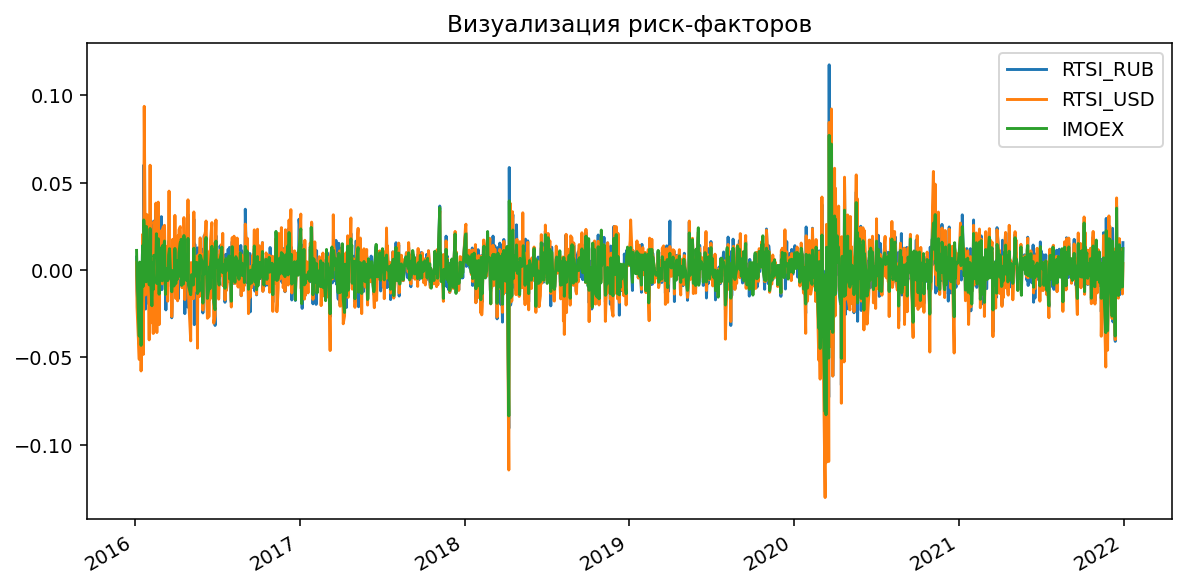

In [272]:
data.plot(title='Визуализация риск-факторов');

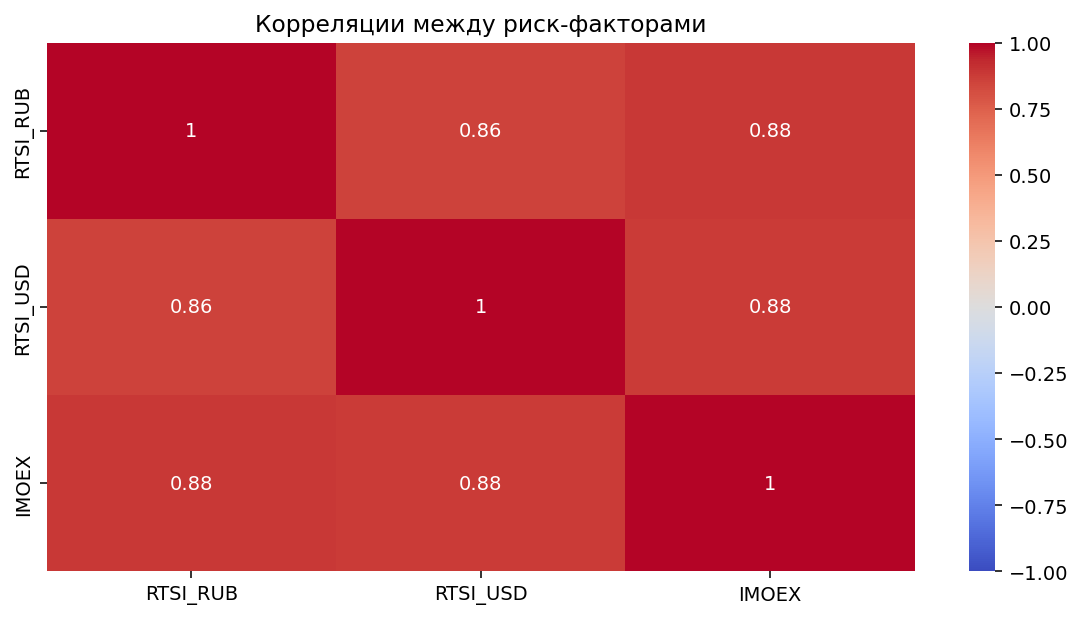

In [273]:
plt.title('Корреляции между риск-факторами')
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1);

array([[<AxesSubplot:title={'center':'CLOSE'}>]], dtype=object)

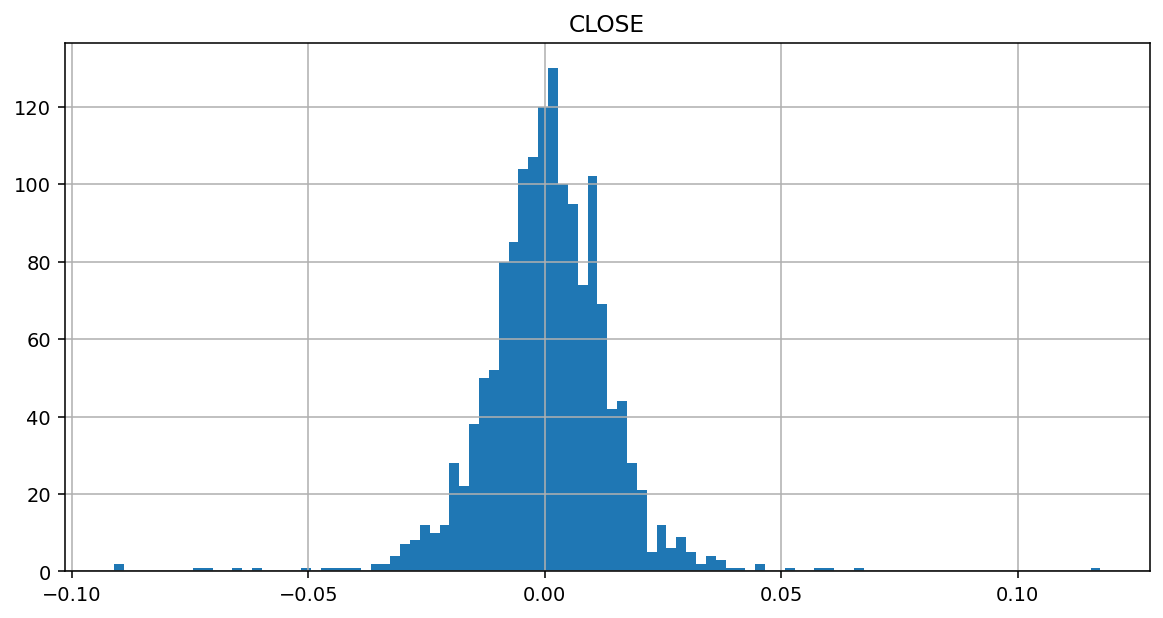

In [274]:
rtsi_DF.pct_change()[1:].CLOSE.to_frame().hist(bins=100)

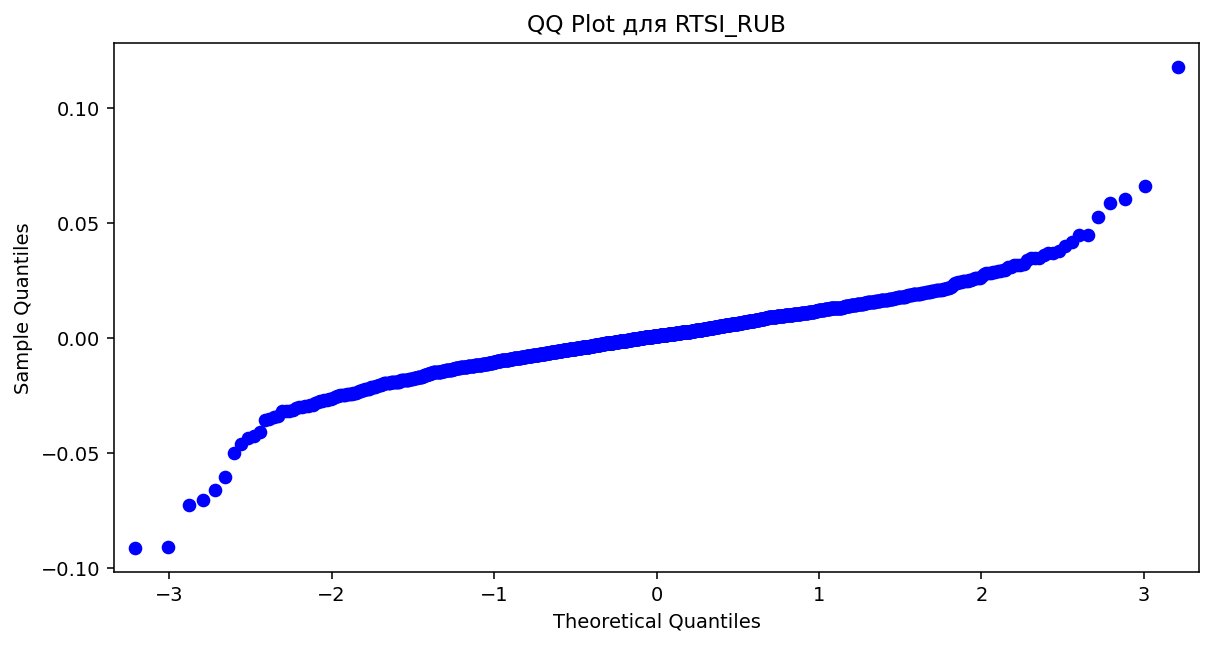

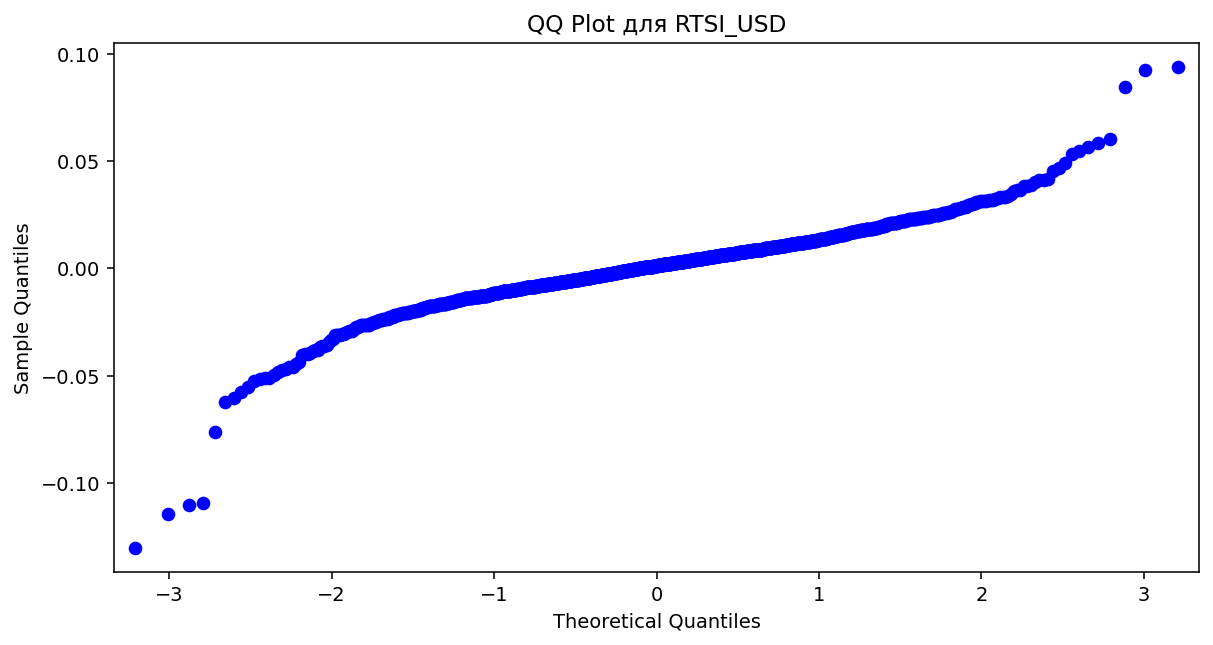

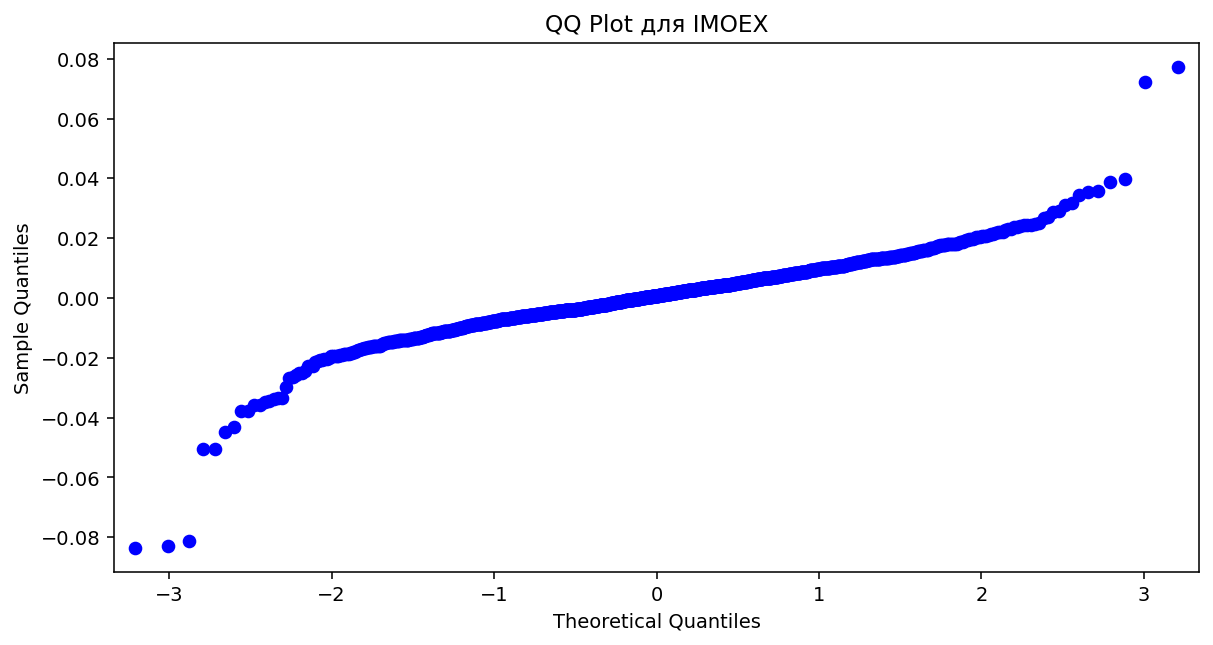

In [275]:
import warnings

for factor in data:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        sm.qqplot(data[factor])

    plt.title(f'QQ Plot для {factor}')
    plt.show()

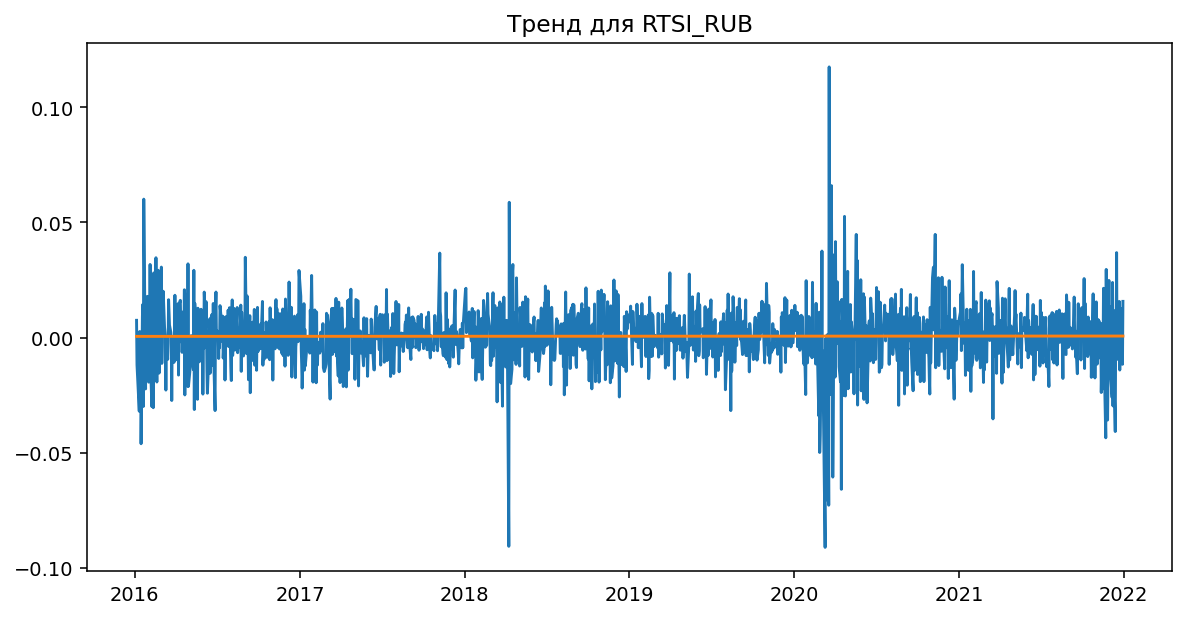

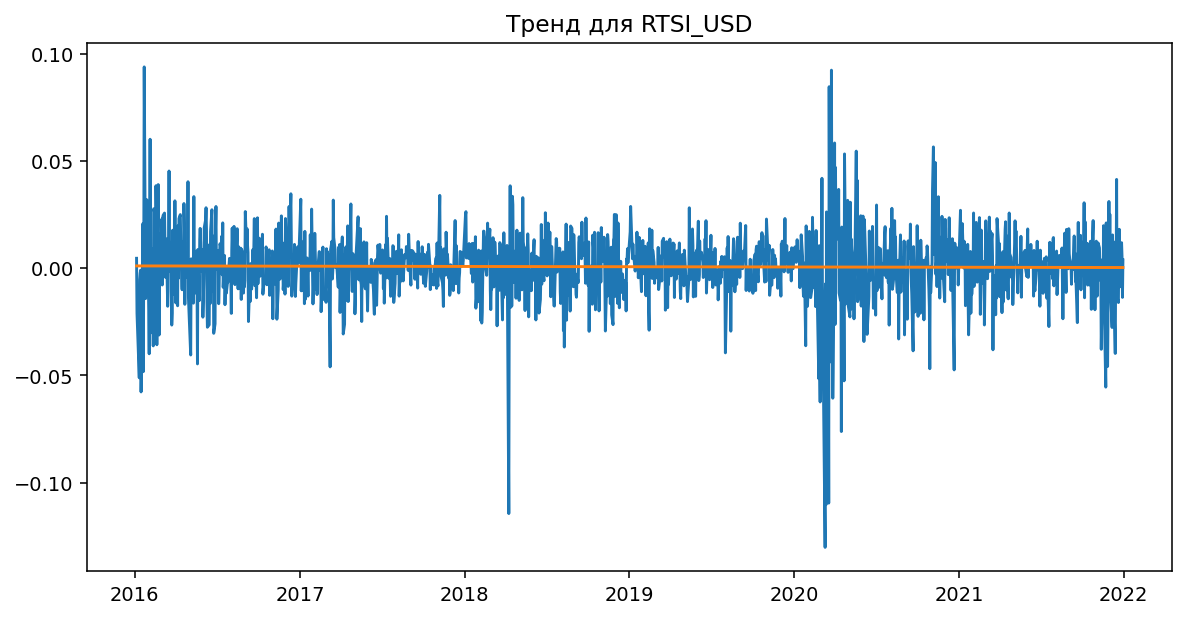

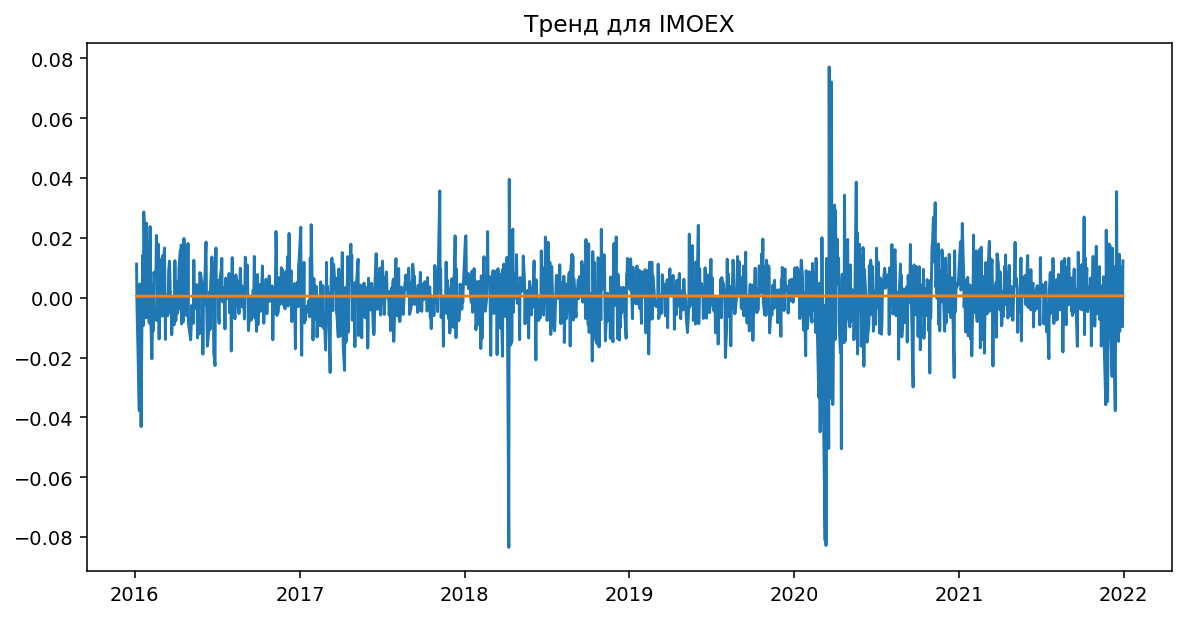

In [276]:
for factor in data:
    x = range(data.shape[0])
    trend_coefs = np.polyfit(x, data[factor], 1)
    trend = np.poly1d(trend_coefs)
    plt.plot(data[factor])
    plt.plot(data.index, trend(x))
    plt.title(f'Тренд для {factor}')
    plt.show()

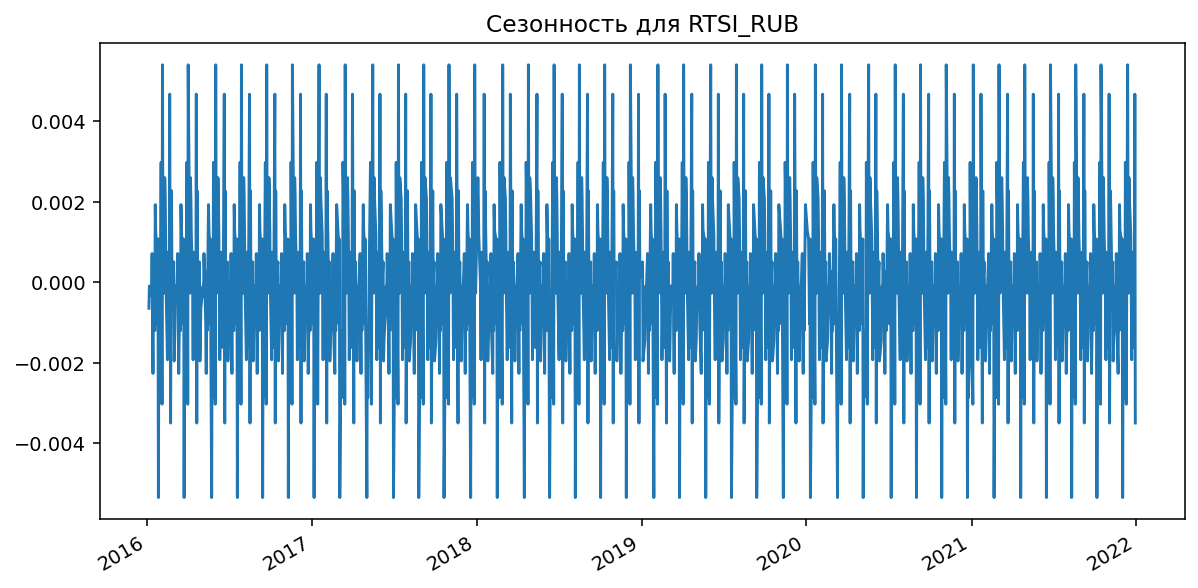

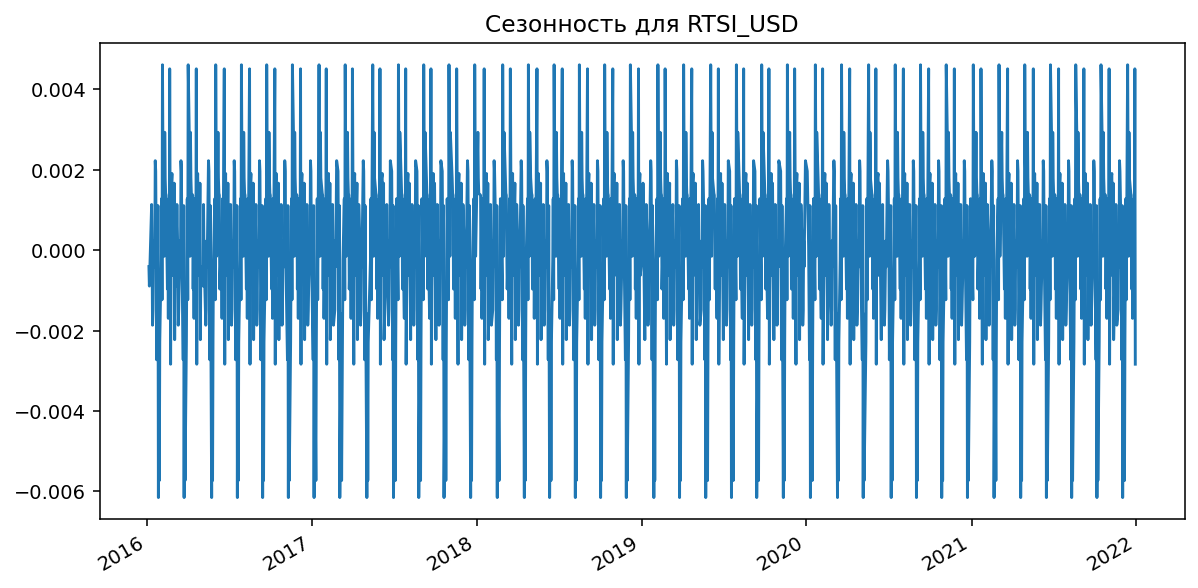

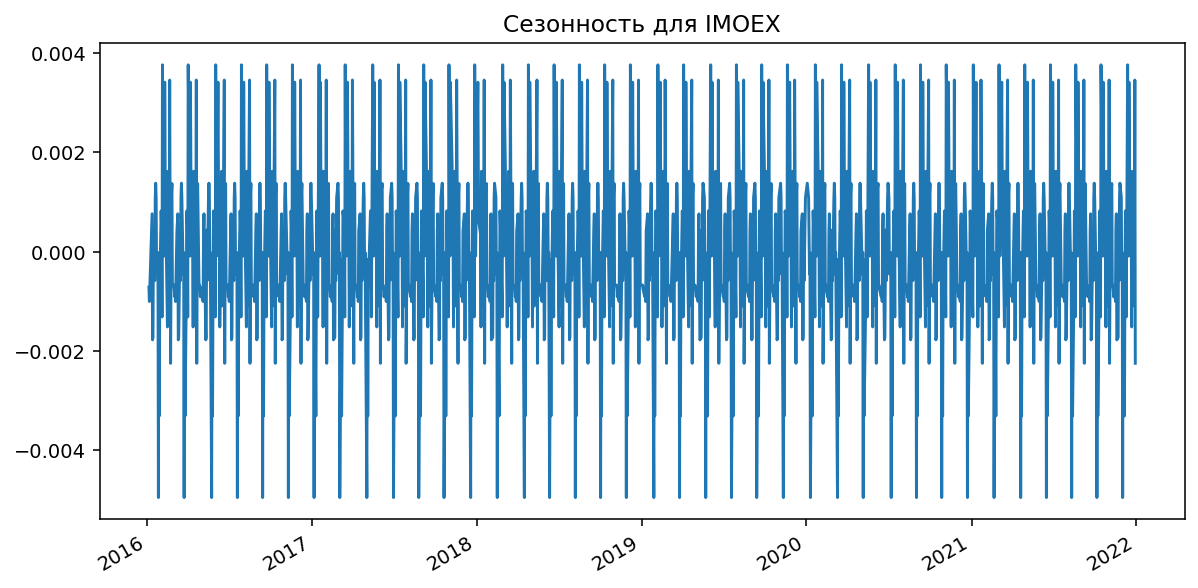

In [277]:
for factor in data:
    season_data = sm.tsa.seasonal_decompose(data[factor], period=40)
    season_data.seasonal.plot()
    plt.title(f'Сезонность для {factor}')
    plt.show()

In [278]:
for factor in data:
    pval = sm.tsa.stattools.adfuller(data[factor])[1]
    print(factor)
    print(f"Критерий Дики-Фуллера: p={pval:.2}")
    print('На уровне значимости 5% гипотеза о нестационарности '
          + 'отвергается' if pval <= 0.05 else 'не отвергается')
    print()

RTSI_RUB
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

RTSI_USD
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

IMOEX
Критерий Дики-Фуллера: p=3.2e-30
На уровне значимости 5% гипотеза о нестационарности отвергается



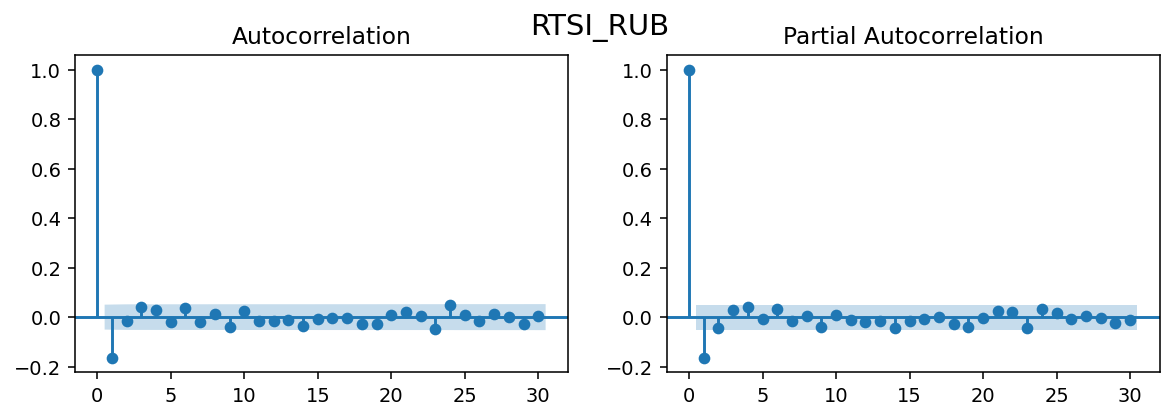

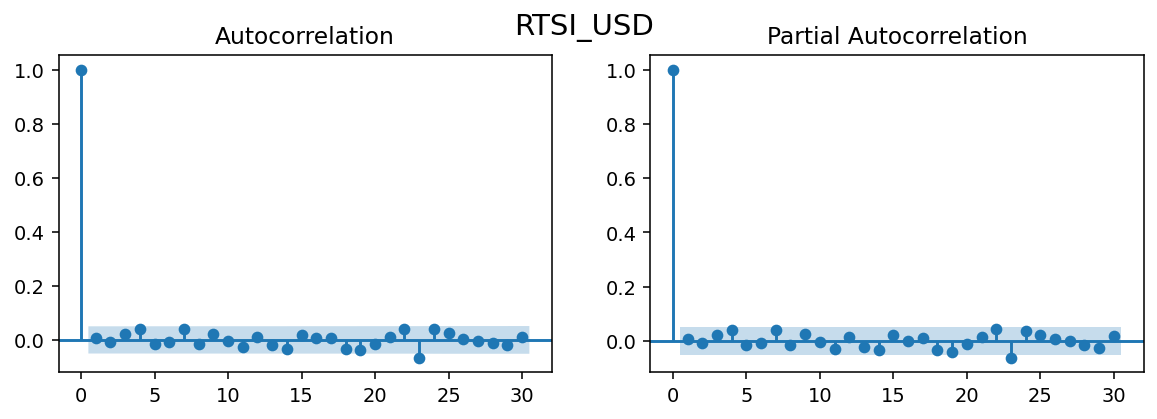

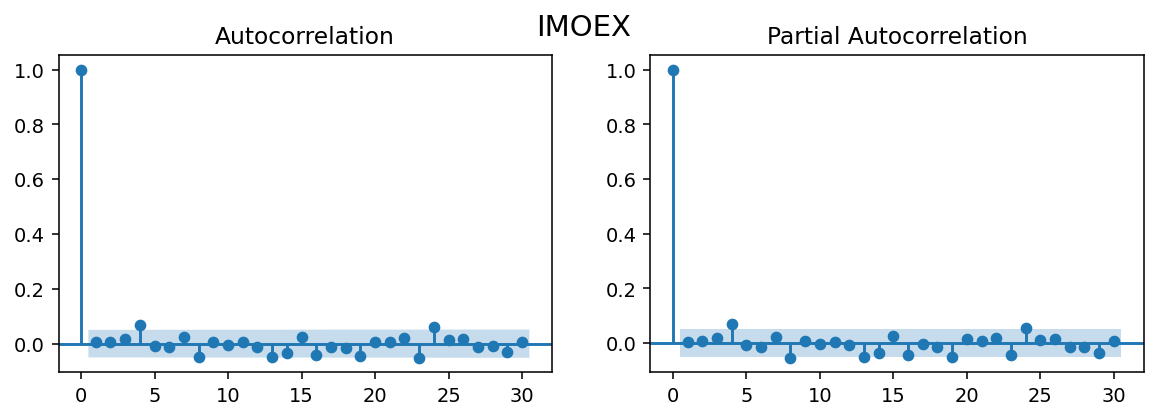

In [279]:
for factor in data:
    fig = plt.figure(figsize=(10, 3))
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))
    sm.graphics.tsa.plot_acf(data[factor], lags=30, ax=acf_ax, alpha=0.05)
    sm.graphics.tsa.plot_pacf(data[factor], lags=30, ax=pacf_ax, alpha=0.05, method='ywm')
    fig.suptitle(factor, fontsize=15)